In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras

# Load the Dataset

In [4]:
import os

data_url='http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
dataset_dir=keras.utils.get_file(origin=data_url,fname='BSR',untar=True)
dataset_dir=os.path.join(dataset_dir,"BSDS500/data")


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

crop_size=300
upscale_factor=3
input_size=crop_size//upscale_factor
batch_size=8

train_dataset=image_dataset_from_directory(dataset_dir,batch_size=batch_size,
image_size=(crop_size,crop_size),validation_split=0.2,subset="training",seed=1330,label_mode=None)

test_dataset=image_dataset_from_directory(dataset_dir,batch_size=batch_size,
image_size=(crop_size,crop_size),validation_split=0.2,subset="validation",seed=1330,label_mode=None)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


# Feature Scaling

In [6]:
def feature_scaling(inputImage):
    inputImage=inputImage/255.0 # 255/255 -> 1 (Max), 0/255 --> 0 (Min)
    return inputImage

train_dataset=train_dataset.map(feature_scaling)
test_dataset=test_dataset.map(feature_scaling)

In [7]:
type(train_dataset)
print(train_dataset)

<MapDataset shapes: (None, 300, 300, 3), types: tf.float32>


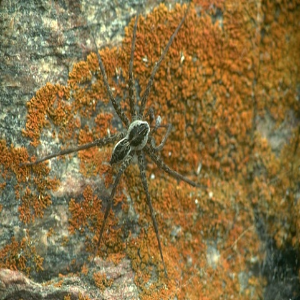

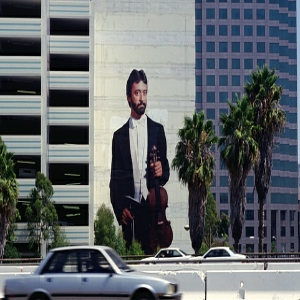

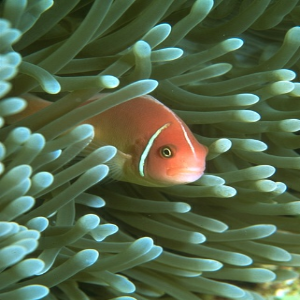

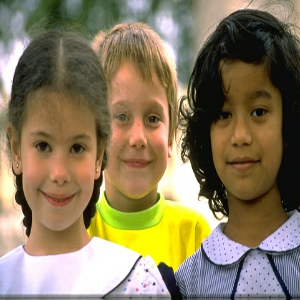

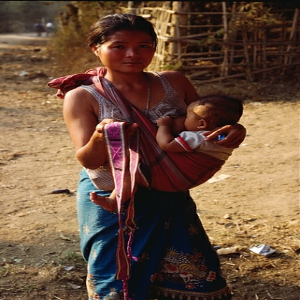

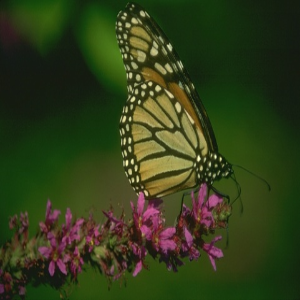

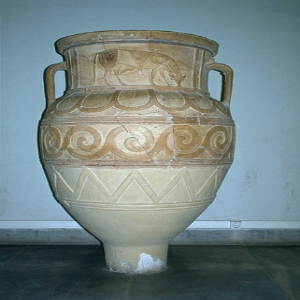

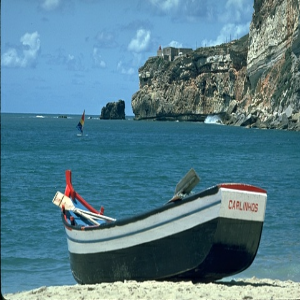

In [8]:
from IPython.display import display
from tensorflow.keras.preprocessing.image import array_to_img

for batch in train_dataset.take(1):
    for img in batch:
        display(array_to_img(img))

In [9]:
dataset=os.path.join(dataset_dir,"images")
test_path=os.path.join(dataset,"test")

test_img_paths=sorted([os.path.join(test_path,fname) 
for fname in os.listdir(test_path) if fname.endswith('.jpg')])

In [10]:
def process_input(input,input_size,upscale_factor):
    input=tf.image.rgb_to_yuv(input)
    last_dimension=len(input.shape)-1
    y,u,v=tf.split(input,3,axis=last_dimension)
    return tf.image.resize(y,[input_size,input_size],method='area')

def process_target(input):
    input=tf.image.rgb_to_yuv(input)
    last_dimension=len(input.shape)-1
    y,u,v=tf.split(input,3,axis=last_dimension)
    return y


In [11]:
train_dataset

<MapDataset shapes: (None, 300, 300, 3), types: tf.float32>

In [12]:
train_dataset=train_dataset.map(lambda x: (process_input(x,input_size,upscale_factor),process_target(x)))

In [13]:
train_dataset=train_dataset.prefetch(buffer_size=32)

In [14]:
test_dataset=test_dataset.map(lambda x: (process_input(x,input_size,upscale_factor),process_target(x)))

In [15]:
test_dataset=test_dataset.prefetch(buffer_size=32)

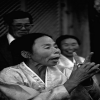

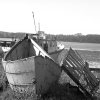

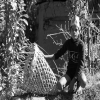

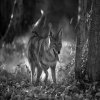

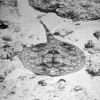

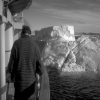

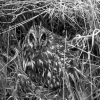

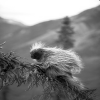

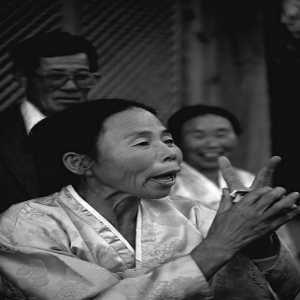

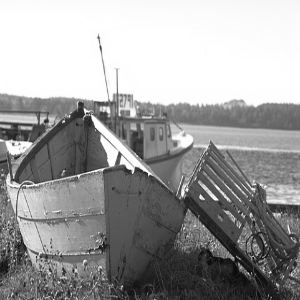

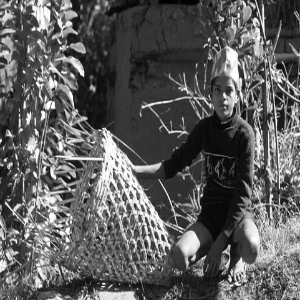

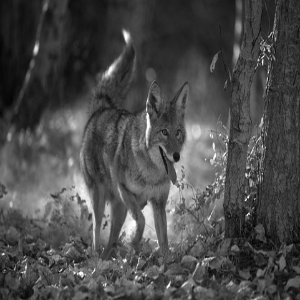

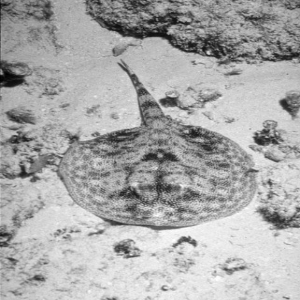

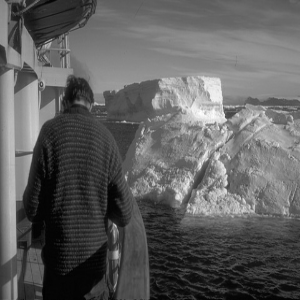

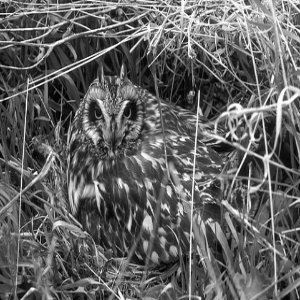

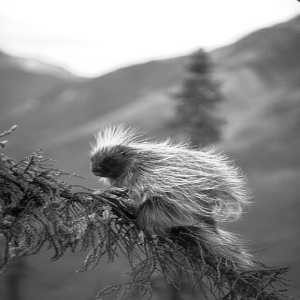

In [16]:
for batch in train_dataset.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [17]:
from tensorflow.keras import layers
def build_model(upscale_factor=3,channels=1):
    conv_arguments={
        'activation':'relu',
        'kernel_initializer':'Orthogonal',
        'padding':'same'
    }

    inputs=keras.Input(shape=(None,None,channels))
    x=layers.Conv2D(64,5,**conv_arguments)(inputs) # Convolution Layer - extract information
    x=layers.Conv2D(64,3,**conv_arguments)(x)
    x=layers.Conv2D(32,3,**conv_arguments)(x)
    x=layers.Conv2D(channels*(upscale_factor**2),3,**conv_arguments)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)

    return keras.Model(inputs,outputs)

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

def plot_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255.0 # max pixel value=255

    fig,ax=plt.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    plt.title(title)
    axins=zoomed_inset_axes(ax,2,loc=2)
    axins.imshow(img_array[::-1],origin='lower')

    x1,x2,y1,y2=200,300,100,200
    axins.set_xlim(x1,x2)
    axins.set_ylim(y1,y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    mark_inset(ax,axins,loc1=1,loc2=3,fc="none",ec="blue")
    plt.savefig(str(prefix)+"-"+title+".png")
    plt.show()



In [19]:
import PIL

def get_lowres_image(img,upscale_factor):
    return img.resize((img.size[0]//upscale_factor,img.size[1]//upscale_factor),PIL.Image.BICUBIC)

In [20]:
import numpy as np

def upscale_image(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y)
    y=y.astype('float32')/255.0

    input=np.expand_dims(y,axis=0)
    out=model.predict(input)

    out_img_y=out[0]
    out_img_y*=255.0

    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape((np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge("YCbCr",(out_img_y,out_img_cb,out_img_cr)).convert('RGB')
    return out_img

In [21]:
from tensorflow.keras.preprocessing.image import load_img
import math

class ModelCallBack(keras.callbacks.Callback):
    def __init__(self):
        super(ModelCallBack,self).__init__()
        self.test_img=get_lowres_image(load_img(test_img_paths[0]),upscale_factor)
    
    # PSNR - Peak Signal to Noise Ratio
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    
    def on_epoch_end(self,epoch,logs=None):
        print("Mean PSNR Ratio for epoch: " %(np.mean(self.psnr)))
        if epoch % 20==0:
            prediction=upscale_image(self.model,self.test_img)
            plot_results(prediction,"epoch-"+str(epoch),"prediction")
    
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs["loss"]))

In [24]:
early_stopping_callback=keras.callbacks.EarlyStopping(monitor='loss',patience=10)
checkpoint_filepath='./tmp/checkpoint'

model_checkpoint_callback=keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
)

model=build_model(upscale_factor=upscale_factor,channels=1)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space_1 (TFOp (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
50/50 - 24s - loss: 0.0277 - val_loss: 0.0061
Mean PSNR Ratio for epoch: 


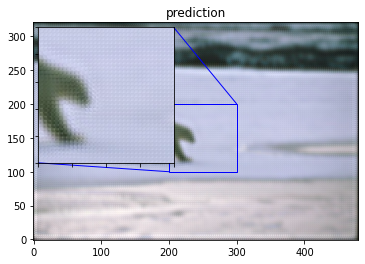

Epoch 2/100
50/50 - 23s - loss: 0.0047 - val_loss: 0.0048
Mean PSNR Ratio for epoch: 
Epoch 3/100
50/50 - 22s - loss: 0.0036 - val_loss: 0.0031
Mean PSNR Ratio for epoch: 
Epoch 4/100
50/50 - 24s - loss: 0.0031 - val_loss: 0.0029
Mean PSNR Ratio for epoch: 
Epoch 5/100
50/50 - 30s - loss: 0.0029 - val_loss: 0.0028
Mean PSNR Ratio for epoch: 
Epoch 6/100
50/50 - 26s - loss: 0.0028 - val_loss: 0.0027
Mean PSNR Ratio for epoch: 
Epoch 7/100
50/50 - 27s - loss: 0.0030 - val_loss: 0.0027
Mean PSNR Ratio for epoch: 
Epoch 8/100
50/50 - 30s - loss: 0.0029 - val_loss: 0.0027
Mean PSNR Ratio for epoch: 
Epoch 9/100
50/50 - 27s - loss: 0.0028 - val_loss: 0.0026
Mean PSNR Ratio for epoch: 
Epoch 10/100
50/50 - 29s - loss: 0.0027 - val_loss: 0.0026
Mean PSNR Ratio for epoch: 
Epoch 11/100
50/50 - 25s - loss: 0.0027 - val_loss: 0.0026
Mean PSNR Ratio for epoch: 
Epoch 12/100
50/50 - 26s - loss: 0.0027 - val_loss: 0.0026
Mean PSNR Ratio for epoch: 
Epoch 13/100
50/50 - 25s - loss: 0.0027 - val_loss:

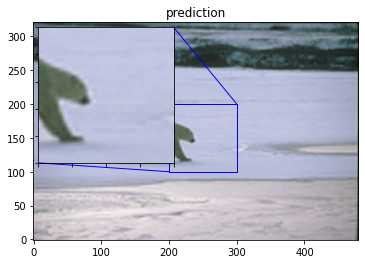

Epoch 22/100
50/50 - 28s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 23/100
50/50 - 28s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 24/100
50/50 - 26s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 25/100
50/50 - 32s - loss: 0.0027 - val_loss: 0.0028
Mean PSNR Ratio for epoch: 
Epoch 26/100
50/50 - 26s - loss: 0.0028 - val_loss: 0.0026
Mean PSNR Ratio for epoch: 
Epoch 27/100
50/50 - 24s - loss: 0.0028 - val_loss: 0.0026
Mean PSNR Ratio for epoch: 
Epoch 28/100
50/50 - 25s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 29/100
50/50 - 24s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 30/100
50/50 - 25s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 31/100
50/50 - 25s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 32/100
50/50 - 27s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 33/100
50/50 - 26s - loss: 0.0026 - v

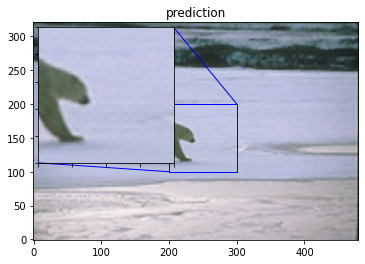

Epoch 42/100
50/50 - 29s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 43/100
50/50 - 30s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 44/100
50/50 - 25s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 45/100
50/50 - 23s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 46/100
50/50 - 24s - loss: 0.0028 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 47/100
50/50 - 25s - loss: 0.0026 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 48/100
50/50 - 25s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 49/100
50/50 - 25s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 50/100
50/50 - 24s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 51/100
50/50 - 23s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 52/100
50/50 - 23s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 53/100
50/50 - 23s - loss: 0.0025 - v

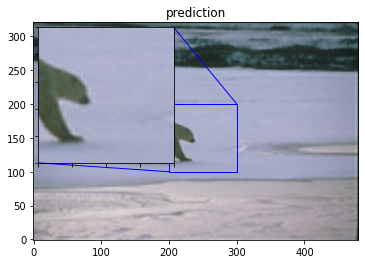

Epoch 62/100
50/50 - 23s - loss: 0.0027 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 63/100
50/50 - 23s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 64/100
50/50 - 22s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 65/100
50/50 - 23s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 66/100
50/50 - 22s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 67/100
50/50 - 22s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 68/100
50/50 - 23s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 69/100
50/50 - 23s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 70/100
50/50 - 22s - loss: 0.0025 - val_loss: 0.0025
Mean PSNR Ratio for epoch: 
Epoch 71/100
50/50 - 22s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 72/100
50/50 - 22s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 73/100
50/50 - 22s - loss: 0.0025 - v

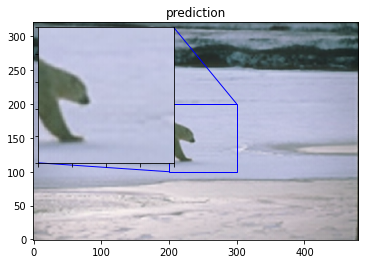

Epoch 82/100
50/50 - 24s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 83/100
50/50 - 24s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 84/100
50/50 - 23s - loss: 0.0025 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 85/100
50/50 - 22s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 86/100
50/50 - 22s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 87/100
50/50 - 23s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 88/100
50/50 - 23s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 89/100
50/50 - 22s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 90/100
50/50 - 22s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 91/100
50/50 - 22s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 92/100
50/50 - 22s - loss: 0.0024 - val_loss: 0.0024
Mean PSNR Ratio for epoch: 
Epoch 93/100
50/50 - 23s - loss: 0.0026 - v

In [25]:
callbacks=[ModelCallBack(),early_stopping_callback,model_checkpoint_callback]
loss_fn=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=0.001)
epochs=100

model.compile(optimizer=optimizer,loss=loss_fn)
model.fit(train_dataset,epochs=epochs,callbacks=callbacks,validation_data=test_dataset,verbose=2)

model.load_weights(checkpoint_filepath)

PSNR of low resolution image and high resolution image is 30.0157
PSNR of predict and high resolution is 30.5922


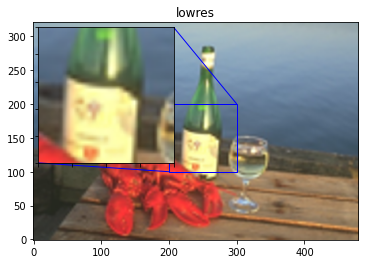

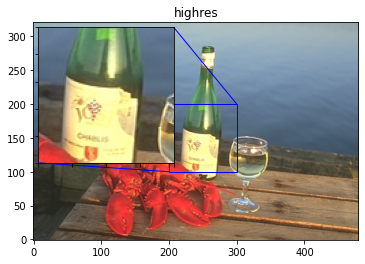

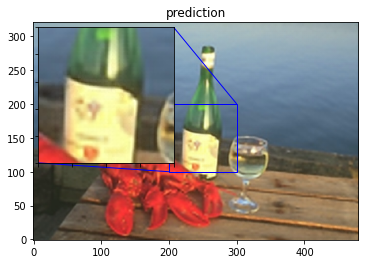

PSNR of low resolution image and high resolution image is 25.1103
PSNR of predict and high resolution is 26.1468


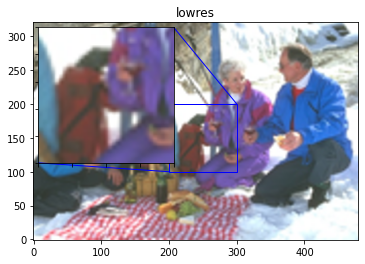

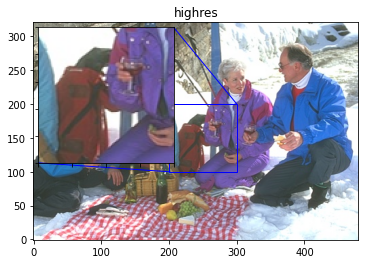

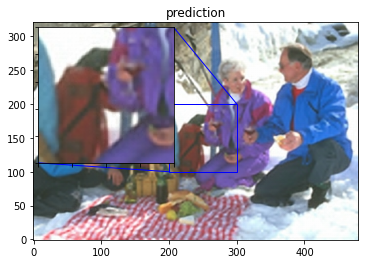

PSNR of low resolution image and high resolution image is 27.7789
PSNR of predict and high resolution is 28.4143


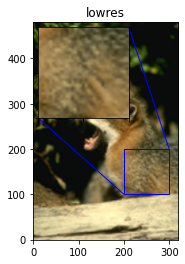

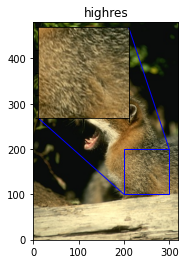

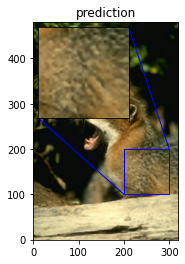

PSNR of low resolution image and high resolution image is 28.0321
PSNR of predict and high resolution is 28.2913


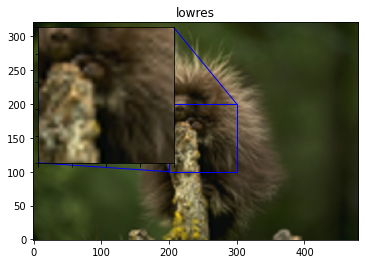

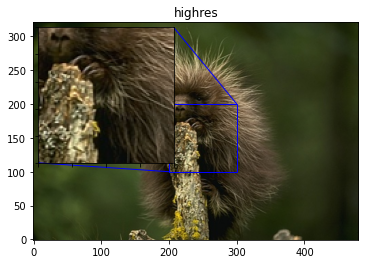

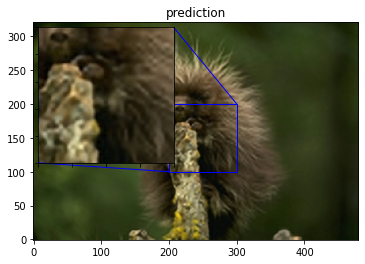

PSNR of low resolution image and high resolution image is 25.7853
PSNR of predict and high resolution is 26.3818


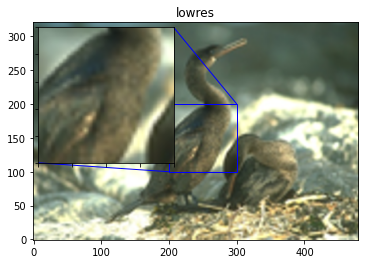

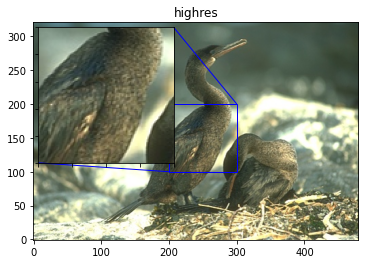

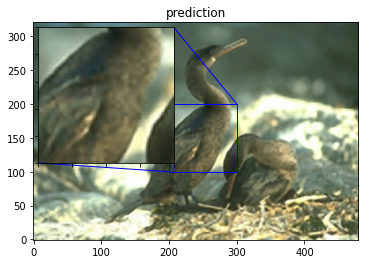

PSNR of low resolution image and high resolution image is 25.9181
PSNR of predict and high resolution is 26.7465


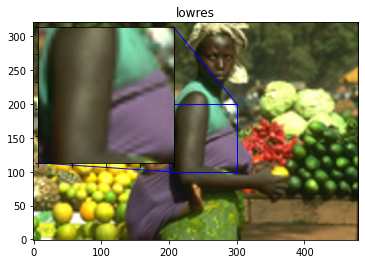

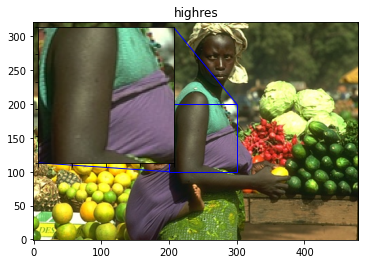

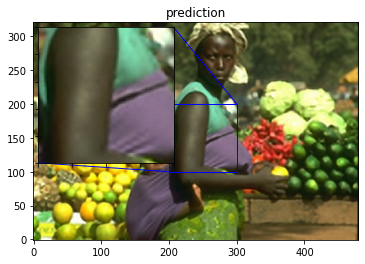

PSNR of low resolution image and high resolution image is 26.2389
PSNR of predict and high resolution is 27.1902


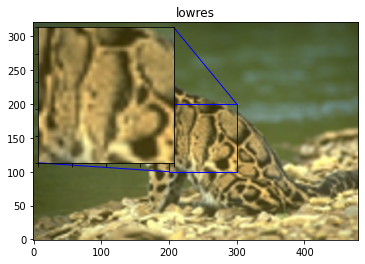

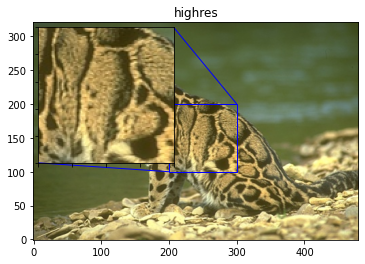

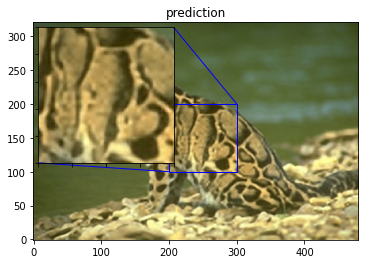

PSNR of low resolution image and high resolution image is 23.3281
PSNR of predict and high resolution is 24.6645


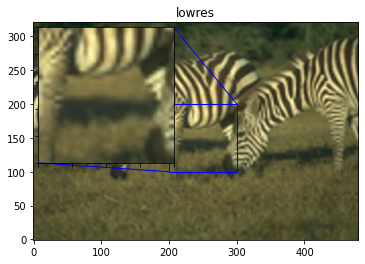

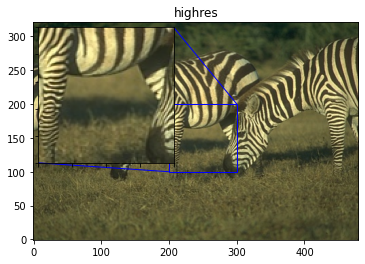

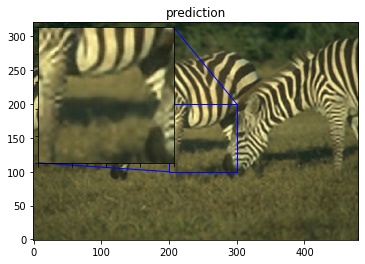

PSNR of low resolution image and high resolution image is 29.9008
PSNR of predict and high resolution is 30.0743


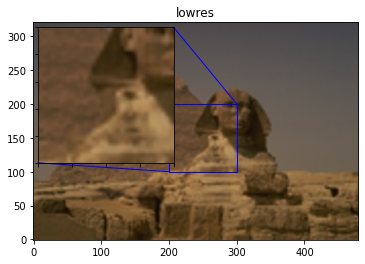

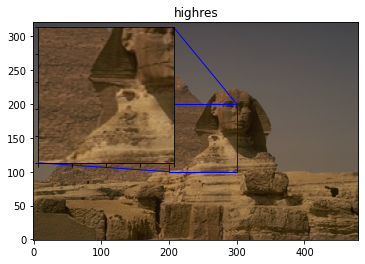

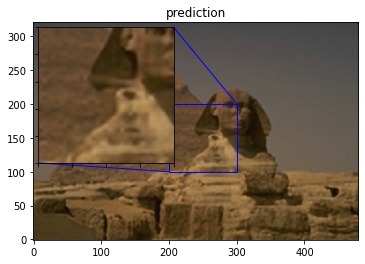

PSNR of low resolution image and high resolution image is 25.2492
PSNR of predict and high resolution is 25.7886


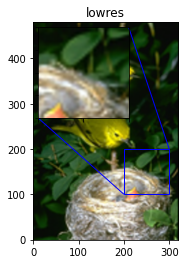

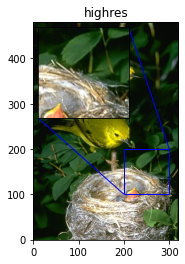

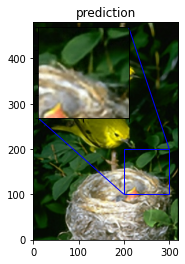

Avg. PSNR of lowres images is 26.7357
Avg. PSNR of reconstructions is 27.4291


In [26]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))